# gdsfactory in 5 minutes

## Component -> Circuit -> Mask

gdsfactory easily enables you to go from a Component, to a higher level Component (circuit), or even higher level Component (Mask)

For a component it's important that you spend some time early to parametrize it correctly. Don't be afraid to spend some time using pen and paper and choosing easy to understand names.

Lets for example define a ring resonator, which is already a circuit made of waveguides, bends and couplers.

Components, circuits and Masks are made in Parametric `cell` functions, that can also accept other ComponentSpec.

A Component Spec can be:

- a parametric cell function (decorated with `cell`)
- a string. To get a cell registered in the active pdk. 
- a dict. `dict(component='mmi2x2', length_mmi=3)`

2022-05-20 16:36:09.604 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.7.1


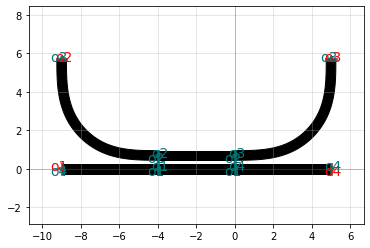

coupler_ring: uid 0, ports ['o2', 'o1', 'o3', 'o4'], aliases [], 0 polygons, 3 references

In [1]:
from typing import Optional

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.components.bend_euler import bend_euler
from gdsfactory.components.coupler90 import coupler90 as coupler90function
from gdsfactory.components.coupler_straight import (
    coupler_straight as coupler_straight_function,
)
from gdsfactory.components.straight import straight as straight_function
from gdsfactory.cross_section import strip
from gdsfactory.snap import assert_on_2nm_grid
from gdsfactory.types import ComponentSpec, CrossSectionSpec


@gf.cell
def coupler_ring(
    gap: float = 0.2,
    radius: float = 5.0,
    length_x: float = 4.0,
    coupler90: ComponentSpec = coupler90function,
    bend: Optional[ComponentSpec] = None,
    straight: ComponentSpec = straight_function,
    coupler_straight: ComponentSpec = coupler_straight_function,
    cross_section: CrossSectionSpec = strip,
    bend_cross_section: Optional[CrossSectionSpec] = None,
    **kwargs
) -> Component:
    r"""Coupler for ring.

    Args:
        gap: spacing between parallel coupled straight waveguides.
        radius: of the bends.
        length_x: length of the parallel coupled straight waveguides.
        coupler90: straight coupled to a 90deg bend.
        bend: bend spec.
        coupler_straight: two parallel coupled straight waveguides.
        cross_section: cross_section spec.
        bend_cross_section: optional bend cross_section spec.
        kwargs: cross_section settings for bend and coupler.

    .. code::

           2             3
           |             |
            \           /
             \         /
           ---=========---
         1    length_x    4


    """
    bend = bend or bend_euler

    c = Component()
    assert_on_2nm_grid(gap)

    # define subcells
    coupler90_component = gf.get_component(
        coupler90,
        gap=gap,
        radius=radius,
        bend=bend,
        cross_section=cross_section,
        bend_cross_section=bend_cross_section,
        **kwargs
    )
    coupler_straight_component = gf.get_component(
        coupler_straight,
        gap=gap,
        length=length_x,
        cross_section=cross_section,
        straight=straight,
        **kwargs
    )

    # add references to subcells
    cbl = c << coupler90_component
    cbr = c << coupler90_component
    cs = c << coupler_straight_component

    # connect references
    y = coupler90_component.y
    cs.connect(port="o4", destination=cbr.ports["o1"])
    cbl.reflect(p1=(0, y), p2=(1, y))
    cbl.connect(port="o2", destination=cs.ports["o2"])

    c.add_port("o1", port=cbl.ports["o3"])
    c.add_port("o2", port=cbl.ports["o4"])
    c.add_port("o3", port=cbr.ports["o3"])
    c.add_port("o4", port=cbr.ports["o4"])
    c.auto_rename_ports()
    return c


coupler = coupler_ring()
coupler

Lets define a ring function that also accepts other component specs for the subcomponents (straight, coupler, bend)

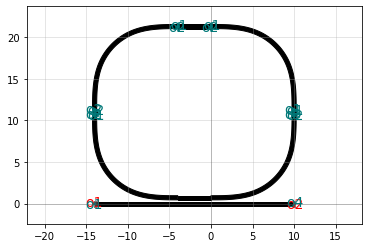

ring_single: uid 9, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references

In [2]:
import gdsfactory as gf

@gf.cell
def ring_single(
    gap: float = 0.2,
    radius: float = 10.0,
    length_x: float = 4.0,
    length_y: float = 0.6,
    coupler_ring: ComponentSpec = coupler_ring,
    straight: ComponentSpec = straight_function,
    bend: ComponentSpec = bend_euler,
    cross_section: ComponentSpec = "strip",
    **kwargs
) -> gf.Component:
    """Returns a single ring.

    ring coupler (cb: bottom) connects to two vertical straights (sl: left, sr: right),
    two bends (bl, br) and horizontal straight (wg: top)

    Args:
        gap: gap between for coupler.
        radius: for the bend and coupler.
        length_x: ring coupler length.
        length_y: vertical straight length.
        coupler_ring: ring coupler spec.
        straight: straight spec.
        bend: 90 degrees bend spec.
        cross_section: cross_section spec.
        kwargs: cross_section settings


    .. code::

          bl-st-br
          |      |
          sl     sr length_y
          |      |
         --==cb==-- gap

          length_x

    """
    gf.snap.assert_on_2nm_grid(gap)

    c = gf.Component()
    cb = c << gf.get_component(
        coupler_ring,
        bend=bend,
        straight=straight,
        gap=gap,
        radius=radius,
        length_x=length_x,
        cross_section=cross_section,
        **kwargs
    )
    sy = gf.get_component(
        straight, length=length_y, cross_section=cross_section, **kwargs
    )
    b = gf.get_component(bend, cross_section=cross_section, radius=radius, **kwargs)
    sx = gf.get_component(
        straight, length=length_x, cross_section=cross_section, **kwargs
    )
    sl = c << sy
    sr = c << sy
    bl = c << b
    br = c << b
    st = c << sx

    sl.connect(port="o1", destination=cb.ports["o2"])
    bl.connect(port="o2", destination=sl.ports["o2"])

    st.connect(port="o2", destination=bl.ports["o1"])
    br.connect(port="o2", destination=st.ports["o1"])
    sr.connect(port="o1", destination=br.ports["o1"])
    sr.connect(port="o2", destination=cb.ports["o3"])

    c.add_port("o2", port=cb.ports["o4"])
    c.add_port("o1", port=cb.ports["o1"])
    return c


ring = ring_single()
ring

How do you customize components?

You can use `functools.partial` to customize the default settings from any component

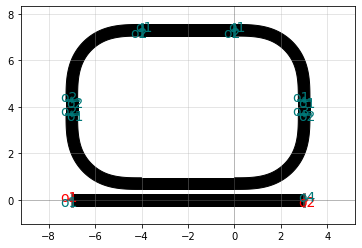

ring_single_f4d868f6: uid 20, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references

In [3]:
ring_single3 = gf.partial(ring_single, radius=3)
ring_single3()

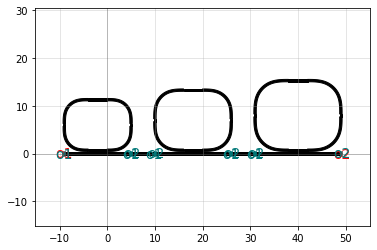

ring_single_array_d7816013: uid 27, ports ['o1', 'o2'], aliases [], 0 polygons, 5 references

In [4]:
ring_array = gf.components.ring_single_array(list_of_dicts = [dict(radius=i) for i in [5, 6, 7]])
ring_array

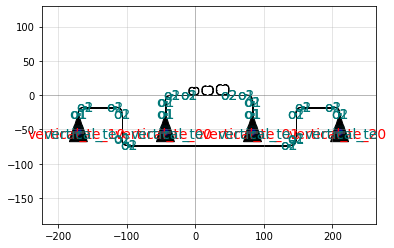

ring_single_array_d7816_34d867e1: uid 49, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_10', 'vertical_te_20'], aliases [], 0 polygons, 22 references

In [5]:
ring_with_grating_couplers = gf.routing.add_fiber_array(ring_array)
ring_with_grating_couplers

### Netlist driven flow

You can define components as a Place and Route netlist.

- instances
- placements
- routes


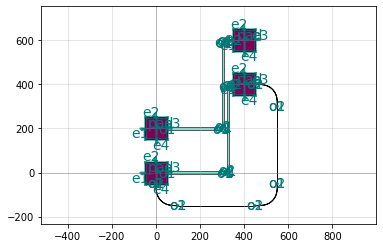

sample_different_factor_20bddbe7: uid 64, ports [], aliases [], 0 polygons, 21 references

In [6]:
import gdsfactory as gf

yaml = """
name: sample_different_factory

instances:
    bl:
      component: pad
    tl:
      component: pad
    br:
      component: pad
    tr:
      component: pad

placements:
    tl:
        x: 0
        y: 200

    br:
        x: 400
        y: 400

    tr:
        x: 400
        y: 600


routes:
    electrical:
        settings:
            separation: 20
            layer: [31, 0]
            width: 10
        links:
            tl,e3: tr,e1
            bl,e3: br,e1
    optical:
        settings:
            radius: 100
        links:
            bl,e4: br,e3

"""

mzi = gf.read.from_yaml(yaml)
mzi

## Mask

Once you have your components and circuits defined, you can add them into a mask.

You need to consider:

- what design variations do you want to include in the mask? You need to define your Design Of Experiment or DOE
- obey DRC (Design rule checking) foundry rules for manufacturability. Foundry usually provides those rules for each layer (min width, min space, min density, max density)
- make sure you will be able to test te devices after fabrication. Obey DFT (design for testing) rules. For exammple, if your test setup works only for fiber array, what is the fiber array spacing (127 or 250um?)
- if you plan to package your device, make sure you follow your packaging guidelines from your packaging house (min pad size, min pad pitch, max number of rows for wire bonding ...)

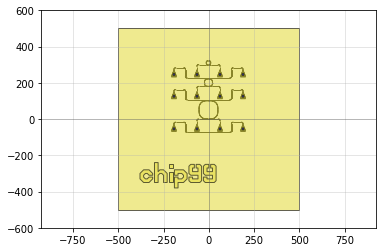

mask: uid 112, ports [], aliases [], 0 polygons, 2 references

In [7]:
import toolz
import gdsfactory as gf

ring_te = toolz.compose(gf.routing.add_fiber_array, gf.components.ring_single)
rings = gf.grid([ring_te(radius=r) for r in [10, 20, 50]])


@gf.cell
def mask(size=(1000, 1000)):
    c = gf.Component()
    c << gf.components.die(size=size)
    c << rings
    return c


m = mask(cache=False)
m

In [8]:
gdspath = m.write_gds_with_metadata(gdspath="mask.gds")

2022-05-20 16:36:14.482 | INFO     | gdsfactory.component:write_gds:1001 - Write GDS to 'mask.gds'


2022-05-20 16:36:15.033 | INFO     | gdsfactory.component:write_gds_with_metadata:1009 - Write YAML metadata to 'mask.yml'


Make sure you save the GDS with metadata so when the chip comes back you remember what you put on it

You can also save the labels for automatic testing.

In [9]:
labels_path = gdspath.with_suffix(".csv")
gf.mask.write_labels(gdspath=gdspath, layer_label=(66, 0))

2022-05-20 16:36:15.044 | INFO     | gdsfactory.mask.write_labels:write_labels:84 - Wrote 12 labels to CSV /home/runner/work/gdsfactory/gdsfactory/docs/notebooks/mask.csv


PosixPath('mask.csv')

In [10]:
mask_metadata = gf.mask.read_metadata(gdspath=gdspath)
tm = gf.mask.merge_test_metadata(mask_metadata=mask_metadata, labels_path=labels_path)

In [11]:
tm.keys()

dict_keys(['ring_single', 'ring_single_d8d11220', 'ring_single_803a01be'])

You want to learn more tutorials?

- Routing: for complex routing.
- Plugins: for simulation interfaces.
    - Mode solvers.
    - FDTD. For simulating Sparameters of each component.
    - Circuit simulators.